<a href="https://colab.research.google.com/github/MoBanerjee/SC4001_Project/blob/main/EfficientNetb0_FullFrozen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Objective of Notebook
### This notebook demonstrates the process of fine-tuning a pre-trained EfficientNet-B0 model on the Flowers102 dataset. In this case, only the classifier layer is trained, while the remaining layers are frozen. We train the model using early stopping to avoid overfitting and evaluate its performance on the test set.

In [ ]:
# necessary imports 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [ ]:
# resize image to 224x224 pixels
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    
    # convert image to tensor
    transforms.ToTensor(),
    
    # normalize image with mean and std 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [ ]:
# load the training data from the Flowers102 dataset
train_data = torchvision.datasets.Flowers102(root='./data', split='train', transform=transform, download=True)

# load the validation data from the Flowers102 dataset
val_data = torchvision.datasets.Flowers102(root='./data', split='val', transform=transform, download=True)

# load the test data from the Flowers102 dataset
test_data = torchvision.datasets.Flowers102(root='./data', split='test', transform=transform, download=True)


100%|██████████| 345M/345M [00:17<00:00, 19.8MB/s]


Extracting data/flowers-102/102flowers.tgz to data/flowers-102


100%|██████████| 502/502 [00:00<00:00, 517kB/s]


100%|██████████| 15.0k/15.0k [00:00<00:00, 13.0MB/s]


In [ ]:
# create a dataloader for the training data with batch size of 32 and shuffle enabled
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

# create a dataloader for the validation data with batch size of 32 and shuffle disabled
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

# create a dataloader for the test data with batch size of 32 and shuffle disabled
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
# load the pre-trained EfficientNet-B0 model
model = torchvision.models.efficientnet_b0(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 190MB/s]


In [ ]:
# replace the final classifier layer to match the number of classes (102 for Flowers102 dataset)
model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=102)

In [ ]:
# set the device to 'cuda' if a GPU is available, otherwise use 'cpu' 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move the model to the selected device (GPU or CPU)
model = model.to(device)

In [ ]:
# define the loss function as cross entropy loss for multi-class classification
criterion = nn.CrossEntropyLoss()

# define the optimizer as Adam, only updating parameters that require gradients
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
# define the training function
def train_model(model, dataloader, criterion, optimizer, device):
    # set the model to training mode (enables dropout, batchnorm, etc.)
    model.train()
    
    # initialize variables to track the loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0
    
    # loop through batches of data
    for inputs, labels in dataloader:
        # move the inputs and labels to the selected device (CPU or GPU)
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the gradients to avoid accumulation from previous steps
        optimizer.zero_grad()
        
        # perform a forward pass through the model to get predictions
        outputs = model(inputs)
        
        # calculate the loss using the predicted outputs and true labels
        loss = criterion(outputs, labels)
        
        # compute gradients via backpropagation
        loss.backward()
        
        # update the model weights based on the gradients
        optimizer.step()
        
        # accumulate the running loss
        running_loss += loss.item()
        
        # get the predicted class by finding the max logit for each input
        _, predicted = torch.max(outputs, 1)
        
        # update total count and correct prediction count
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # return the average loss and accuracy for the epoch
    return running_loss / len(dataloader), correct / total


In [ ]:
# define the validation function
def validate_model(model, dataloader, criterion, device):
    # set the model to evaluation mode (disables dropout, batchnorm, etc.)
    model.eval()
    
    # initialize variables to track the loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0
    
    # disable gradient computation for validation 
    with torch.no_grad():
        # loop through batches of data
        for inputs, labels in dataloader:
            # move the inputs and labels to the selected device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # perform a forward pass through the model to get predictions
            outputs = model(inputs)
            
            # calculate the loss using the predicted outputs and true labels
            loss = criterion(outputs, labels)
            
            # accumulate the running loss
            running_loss += loss.item()
            
            # get the predicted class by finding the max logit for each input
            _, predicted = torch.max(outputs, 1)
            
            # update total count and correct prediction count
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # return the average loss and accuracy for the validation set
    return running_loss / len(dataloader), correct / total


In [ ]:
# define the test function
def test_model(model, dataloader, device):
    # set the model to evaluation mode (disables dropout, batchnorm, etc.)
    model.eval()
    
    # initialize variables to track the number of correct predictions and total samples
    correct = 0
    total = 0
    
    # disable gradient computation for testing 
    with torch.no_grad():
        # loop through batches of data
        for inputs, labels in dataloader:
            # move the inputs and labels to the selected device (CPU or GPU)
            inputs, labels = inputs.to(device), labels.to(device)
            
            # perform a forward pass through the model to get predictions
            outputs = model(inputs)
            
            # get the predicted class by finding the max logit for each input
            _, predicted = torch.max(outputs, 1)
            
            # update total count and correct prediction count
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # return the accuracy over the entire test dataset
    return correct / total

In [ ]:
# set the number of epochs for training
num_epochs = 100

# initialize the best validation accuracy to track the highest performance
best_val_acc = 0.0

# set the patience for early stopping (how many epochs to wait for improvement)
patience = 5

# initialize counter to track epochs without improvement
counter = 0

# lists to store the history of training and validation losses and accuracies
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# loop over the number of epochs for training
for epoch in range(num_epochs):
    # train the model on the training set and get loss and accuracy
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    
    # validate the model on the validation set and get loss and accuracy
    val_loss, val_acc = validate_model(model, val_loader, criterion, device)
    
    # append the results for this epoch to the history lists
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    # print the loss and accuracy for the current epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # check if the validation accuracy has improved
    if val_acc > best_val_acc:
        # update the best validation accuracy
        best_val_acc = val_acc
        # save the model with the best validation accuracy
        torch.save(model.state_dict(), 'Best_EfficientNetb0_FullFrozen.pth')
        # reset the counter after an improvement
        counter = 0
    else:
        # increment the counter when no improvement
        counter += 1

    # check if early stopping condition is met
    if counter >= patience:
        # print early stopping message and exit loop
        print(f"Early stopping at epoch {epoch+1}. No improvement in validation accuracy for {patience} consecutive epochs.")
        break


Epoch [1/100], Train Loss: 3.7032, Train Accuracy: 0.2725, Validation Loss: 1.8710, Validation Accuracy: 0.5618
Epoch [2/100], Train Loss: 1.1603, Train Accuracy: 0.7833, Validation Loss: 0.7783, Validation Accuracy: 0.8157
Epoch [3/100], Train Loss: 0.2786, Train Accuracy: 0.9578, Validation Loss: 0.5591, Validation Accuracy: 0.8569
Epoch [4/100], Train Loss: 0.1105, Train Accuracy: 0.9814, Validation Loss: 0.4746, Validation Accuracy: 0.8725
Epoch [5/100], Train Loss: 0.0757, Train Accuracy: 0.9873, Validation Loss: 0.4597, Validation Accuracy: 0.8755
Epoch [6/100], Train Loss: 0.0451, Train Accuracy: 0.9961, Validation Loss: 0.4612, Validation Accuracy: 0.8745
Epoch [7/100], Train Loss: 0.0379, Train Accuracy: 0.9941, Validation Loss: 0.4821, Validation Accuracy: 0.8627
Epoch [8/100], Train Loss: 0.0308, Train Accuracy: 0.9951, Validation Loss: 0.5000, Validation Accuracy: 0.8637
Epoch [9/100], Train Loss: 0.0414, Train Accuracy: 0.9922, Validation Loss: 0.4737, Validation Accuracy:

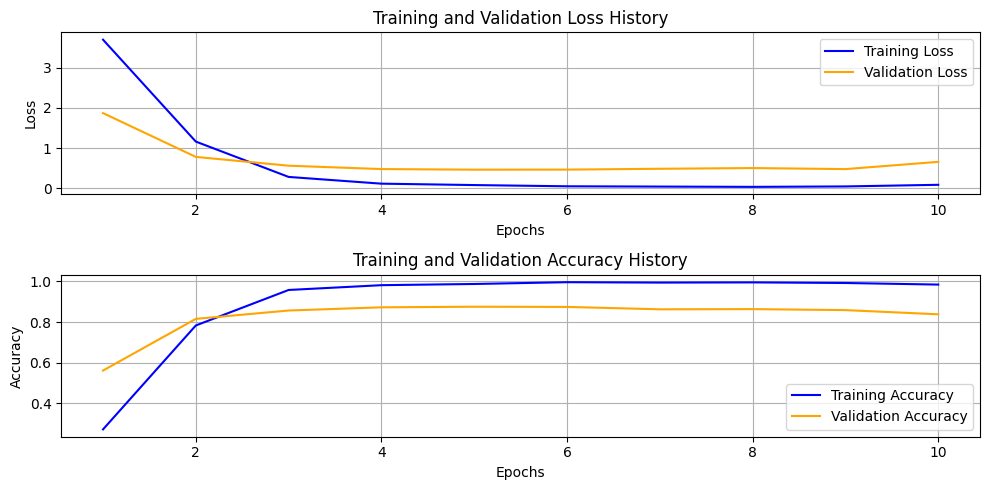

In [ ]:
# cell for plotting training and validation metrics
import matplotlib.pyplot as plt
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'orange', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'orange', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [ ]:
# evaluating best model saved earlier on test dataset
model.load_state_dict(torch.load('Best_EfficientNetb0_FullFrozen.pth'))
test_acc = test_model(model, test_loader, device)
print(f"Test Accuracy: {test_acc:.4f}")

<ipython-input-14-827b0db27e9a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Best_EfficientNetb0_FullFrozen.pth'))


Test Accuracy: 0.8557


## Analysis of Results
### The training and validation loss plots show a consistent decrease, with training loss dropping more quickly than validation loss. By around the 5th epoch, the training loss nearly plateaus, while the validation loss stabilizes slightly above the training curve, indicating minimal overfitting. The accuracy plots show a rapid increase in training accuracy, reaching near-perfect levels by the 5th epoch, while validation accuracy stabilizes around 0.87, suggesting good generalization. Early stopping halted training at the 10th epoch due to no further improvement in validation accuracy, resulting in a final test accuracy of 0.8557, consistent with validation performance.